# Fine-tuning the VisualDocumentNer on dataset from the Annatation Lab

In [1]:
license = ""
secret = ""
aws_access_key = ""
aws_secret_key = ""

version = secret.split("-")[0]
spark_ocr_jar_path = "../../../target/scala-2.12"

In [19]:
# %pip install ../../../python/dist/spark-ocr-4.4.4rc1.tar.gz
%pip install transformers[torch]
%pip install onnxruntime==1.13.1 onnx==1.13.0
%pip install evaluate==0.4.0 seqeval==1.2.2
%pip install --force-reinstall optimum
%pip install accelerate -U

Processing /Users/nmelnik/IdeaProjects/spark-ocr/python/dist/spark-ocr-4.4.4rc1.tar.gz
DEPRECATION: Source distribution is being reinstalled despite an installed package having the same name and version as the installed package. pip 21.3 will remove support for this functionality. A possible replacement is use --force-reinstall. You can find discussion regarding this at https://github.com/pypa/pip/issues/8711.
  Created wheel for spark-ocr: filename=spark_ocr-4.4.4rc1-py3-none-any.whl size=40004955 sha256=6858ed35ba266c1e1073e3999d7db011feccafde2cbaa282b6095a1ca2dee795
  Stored in directory: /Users/nmelnik/Library/Caches/pip/wheels/cc/cc/5f/384cc09bb9db8315ab2285516ae0050ef30850524df6ab4391
Successfully built spark-ocr


  Attempting uninstall: spark-ocr
    Found existing installation: spark-ocr 4.4.4rc1
    Uninstalling spark-ocr-4.4.4rc1:
      Successfully uninstalled spark-ocr-4.4.4rc1
You should consider upgrading via the '/Users/nmelnik/.local/share/virtualenvs/OcrMissedPages-W3gpzUuJ/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## Initialization of spark session

In [2]:
from sparkocr import start
import os
import sys

if license:
    os.environ['JSL_OCR_LICENSE'] = license
    os.environ['SPARK_NLP_LICENSE'] = license

if aws_access_key:
    os.environ['AWS_ACCESS_KEY'] = aws_access_key
    os.environ['AWS_SECRET_ACCESS_KEY'] = aws_secret_key


spark = start(secret=secret,
              jar_path=spark_ocr_jar_path)

spark

Spark version: 3.2.1
Spark NLP version: 4.4.4
Spark NLP for Healthcare version: 4.4.2
Spark OCR version: 4.4.4rc4



In [4]:
import os
import sys

import sparkocr
from sparkocr.transformers import *
from sparkocr.utils import *
from sparkocr.enums import *

from pyspark.ml import PipelineModel, Pipeline
from sparkocr.transformers.readers.alab_readers import AlabReadersV1

# Download dataset

In [4]:
!wget https://johnsnowlabs-my.sharepoint.com/:u:/p/mykola/Ea4qzIC1Q6ZAglll6b1g-LIBe3OYyesevgfaNOYP9UfGAA?download=1 -O ./dataset.zip
!unzip ./dataset.zip

--2023-07-06 08:01:58--  https://johnsnowlabs-my.sharepoint.com/:u:/p/mykola/Ea4qzIC1Q6ZAglll6b1g-LIBe3OYyesevgfaNOYP9UfGAA?download=1
Resolving johnsnowlabs-my.sharepoint.com (johnsnowlabs-my.sharepoint.com)... 13.107.136.8, 13.107.138.8
Connecting to johnsnowlabs-my.sharepoint.com (johnsnowlabs-my.sharepoint.com)|13.107.136.8|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/mykola_johnsnowlabs_com/Documents/%d0%a4%d0%b0%d0%b9%d0%bb%d1%8b%20%d1%87%d0%b0%d1%82%d0%be%d0%b2%20Microsoft%20Teams/2023-06-15-09-05-29_Key_Value_10K_Forms.zip?ga=1 [following]
--2023-07-06 08:02:00--  https://johnsnowlabs-my.sharepoint.com/personal/mykola_johnsnowlabs_com/Documents/%d0%a4%d0%b0%d0%b9%d0%bb%d1%8b%20%d1%87%d0%b0%d1%82%d0%be%d0%b2%20Microsoft%20Teams/2023-06-15-09-05-29_Key_Value_10K_Forms.zip?ga=1
Reusing existing connection to johnsnowlabs-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 39272257 (37M) [application/x-zip-compre

# Read dataset to teh dataframe

In [5]:
df = AlabReadersV1().dataLabeler(spark,
            path="./2023-06-15-09-05-29_Key_Value_10K_Forms", doc_type="image")

In [6]:
df.count()

61

# Show few records of the dataset


    Image #0:
    Origin: /images/1078/t5-1663287709.jpg
    Resolution: 0 dpi
    Width: 3162 px
    Height: 1249 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


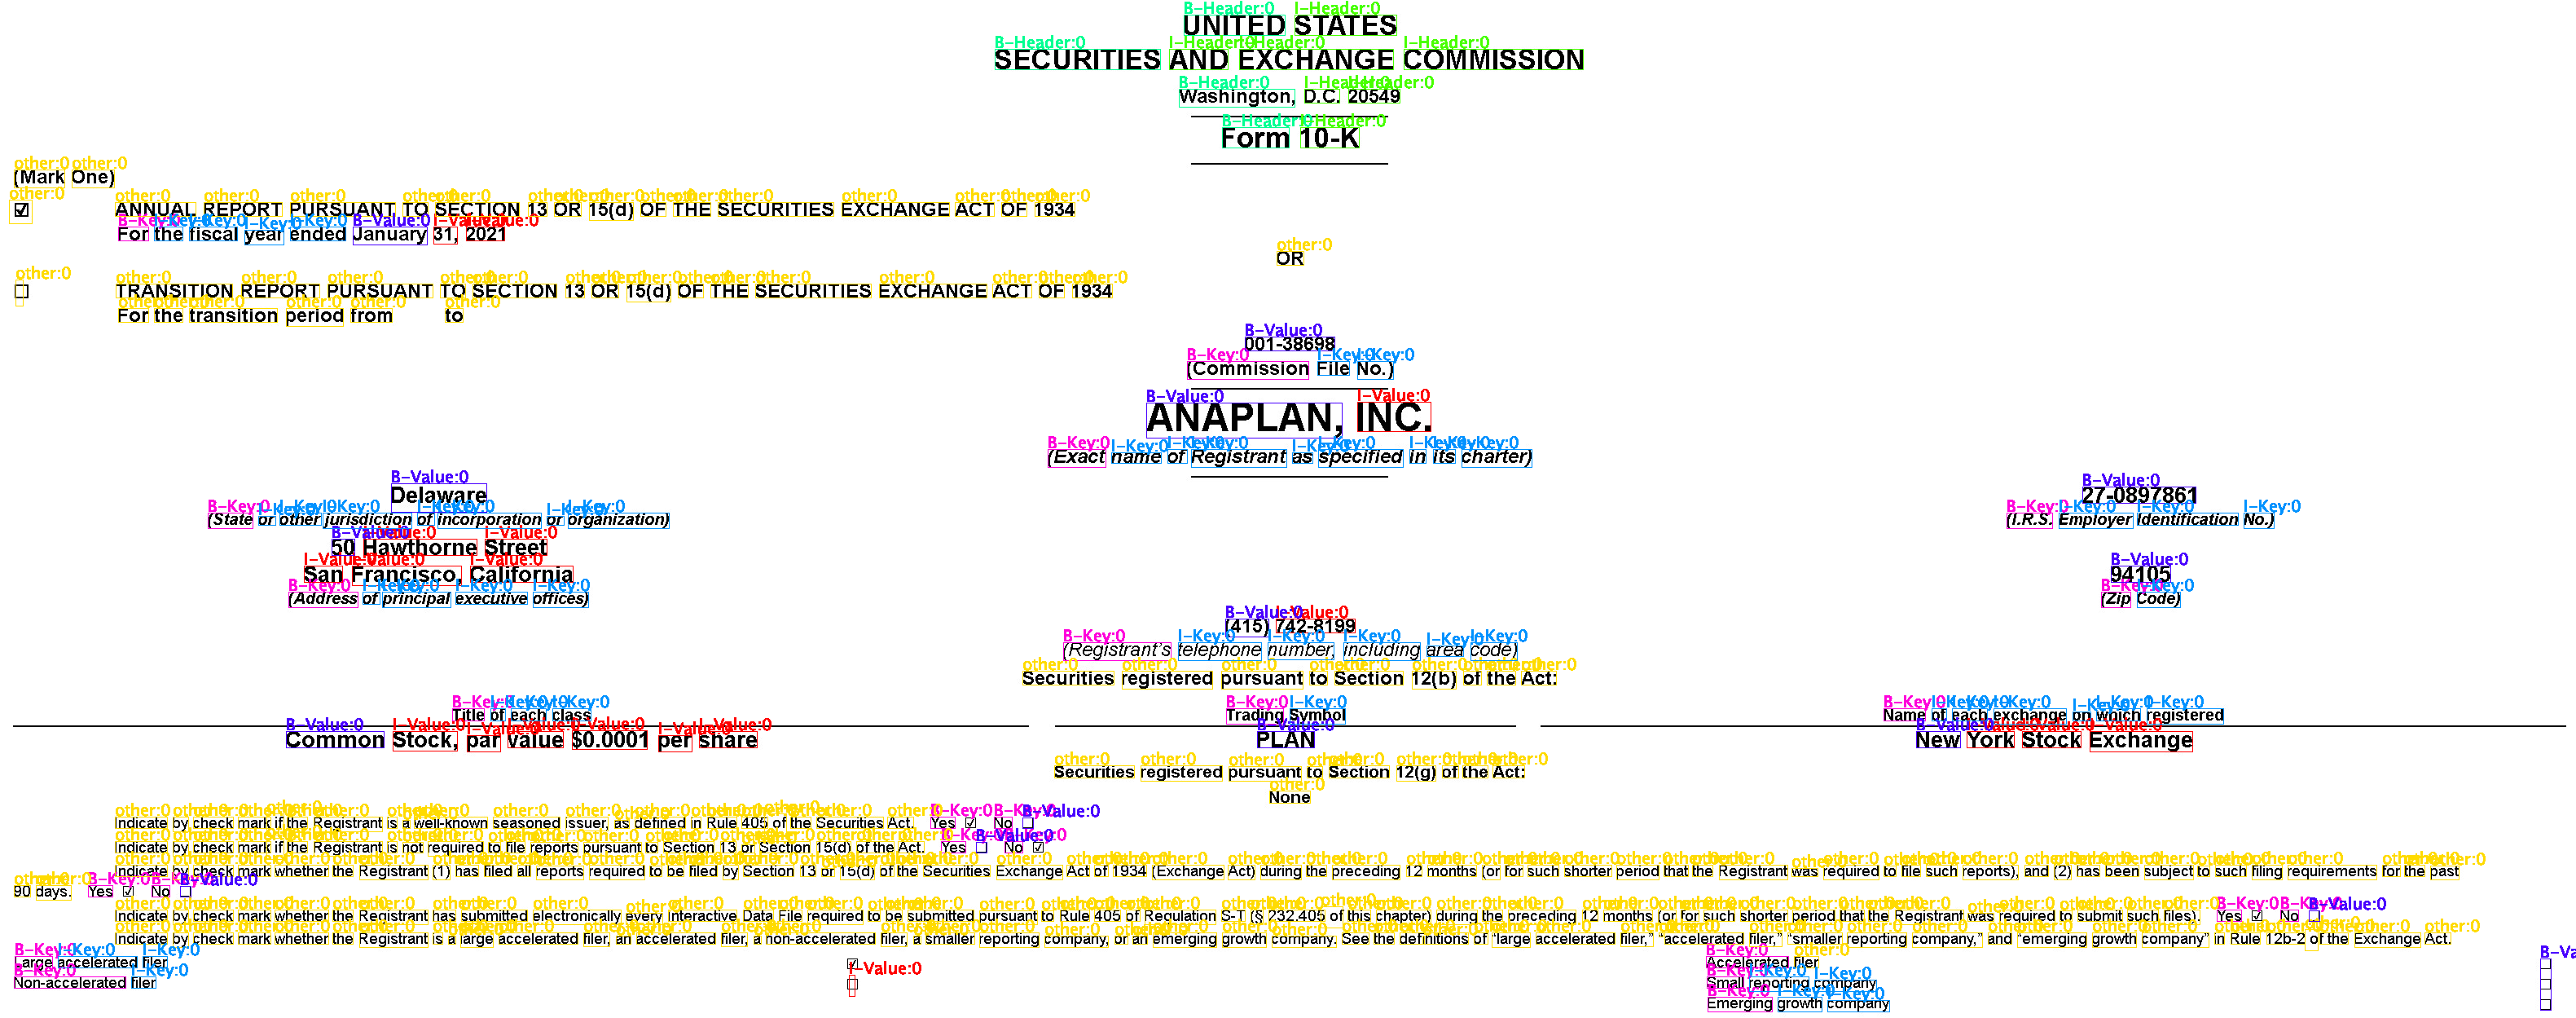


    Image #1:
    Origin: /images/1078/17-1663195730.jpg
    Resolution: 0 dpi
    Width: 3160 px
    Height: 1472 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


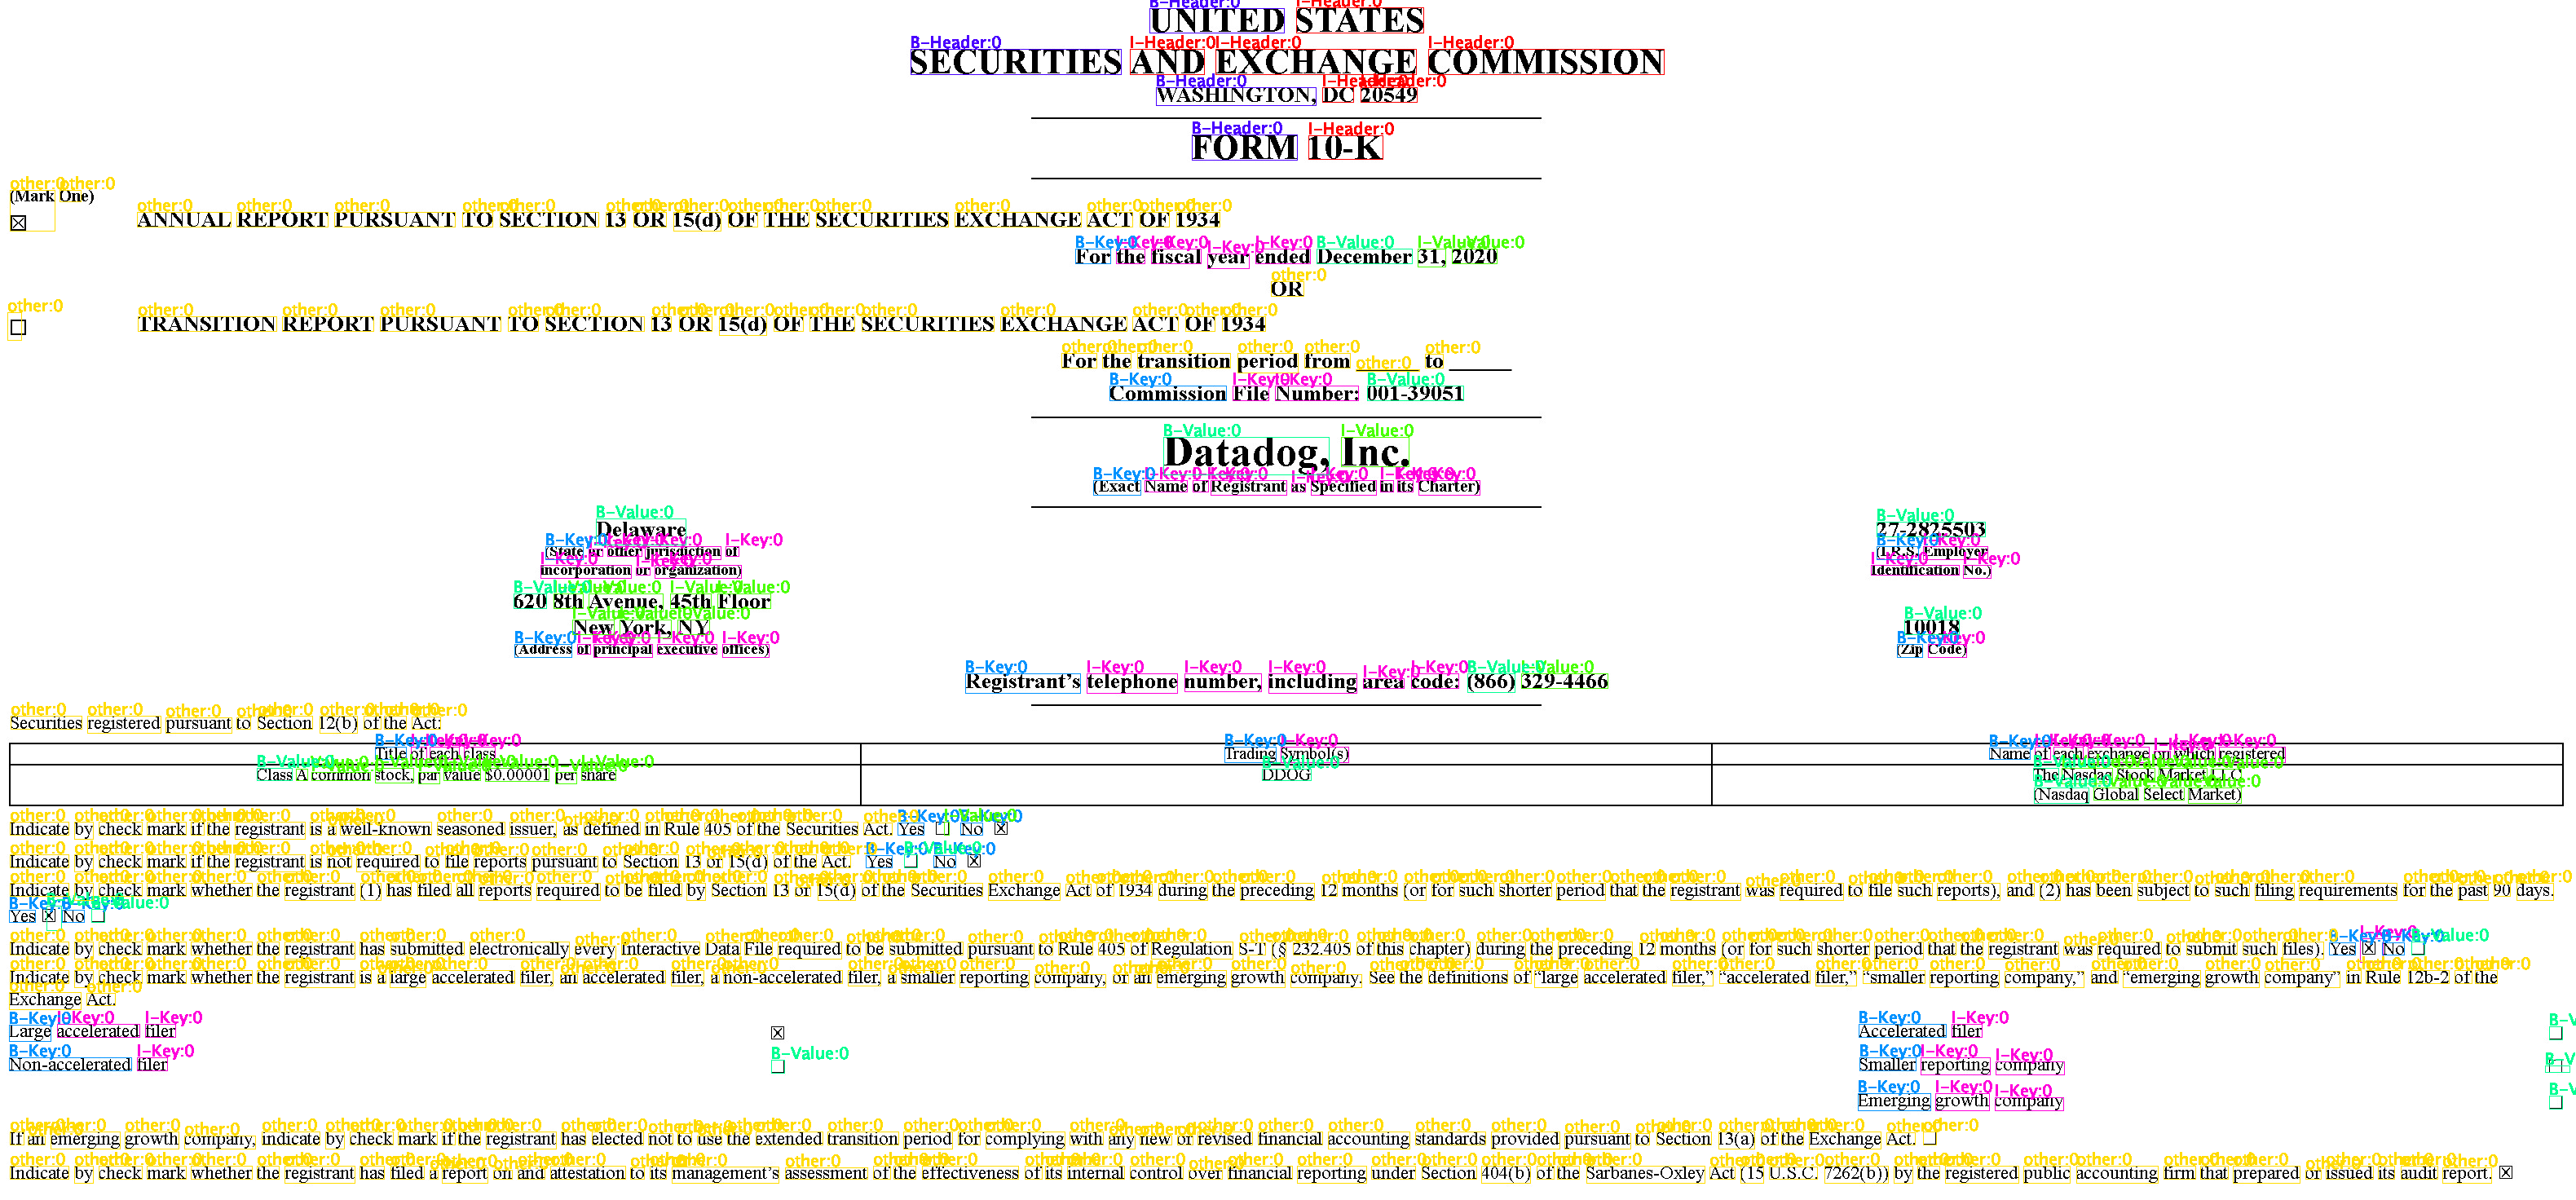


    Image #2:
    Origin: /images/1078/t7-1663287765.jpg
    Resolution: 0 dpi
    Width: 3162 px
    Height: 1408 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


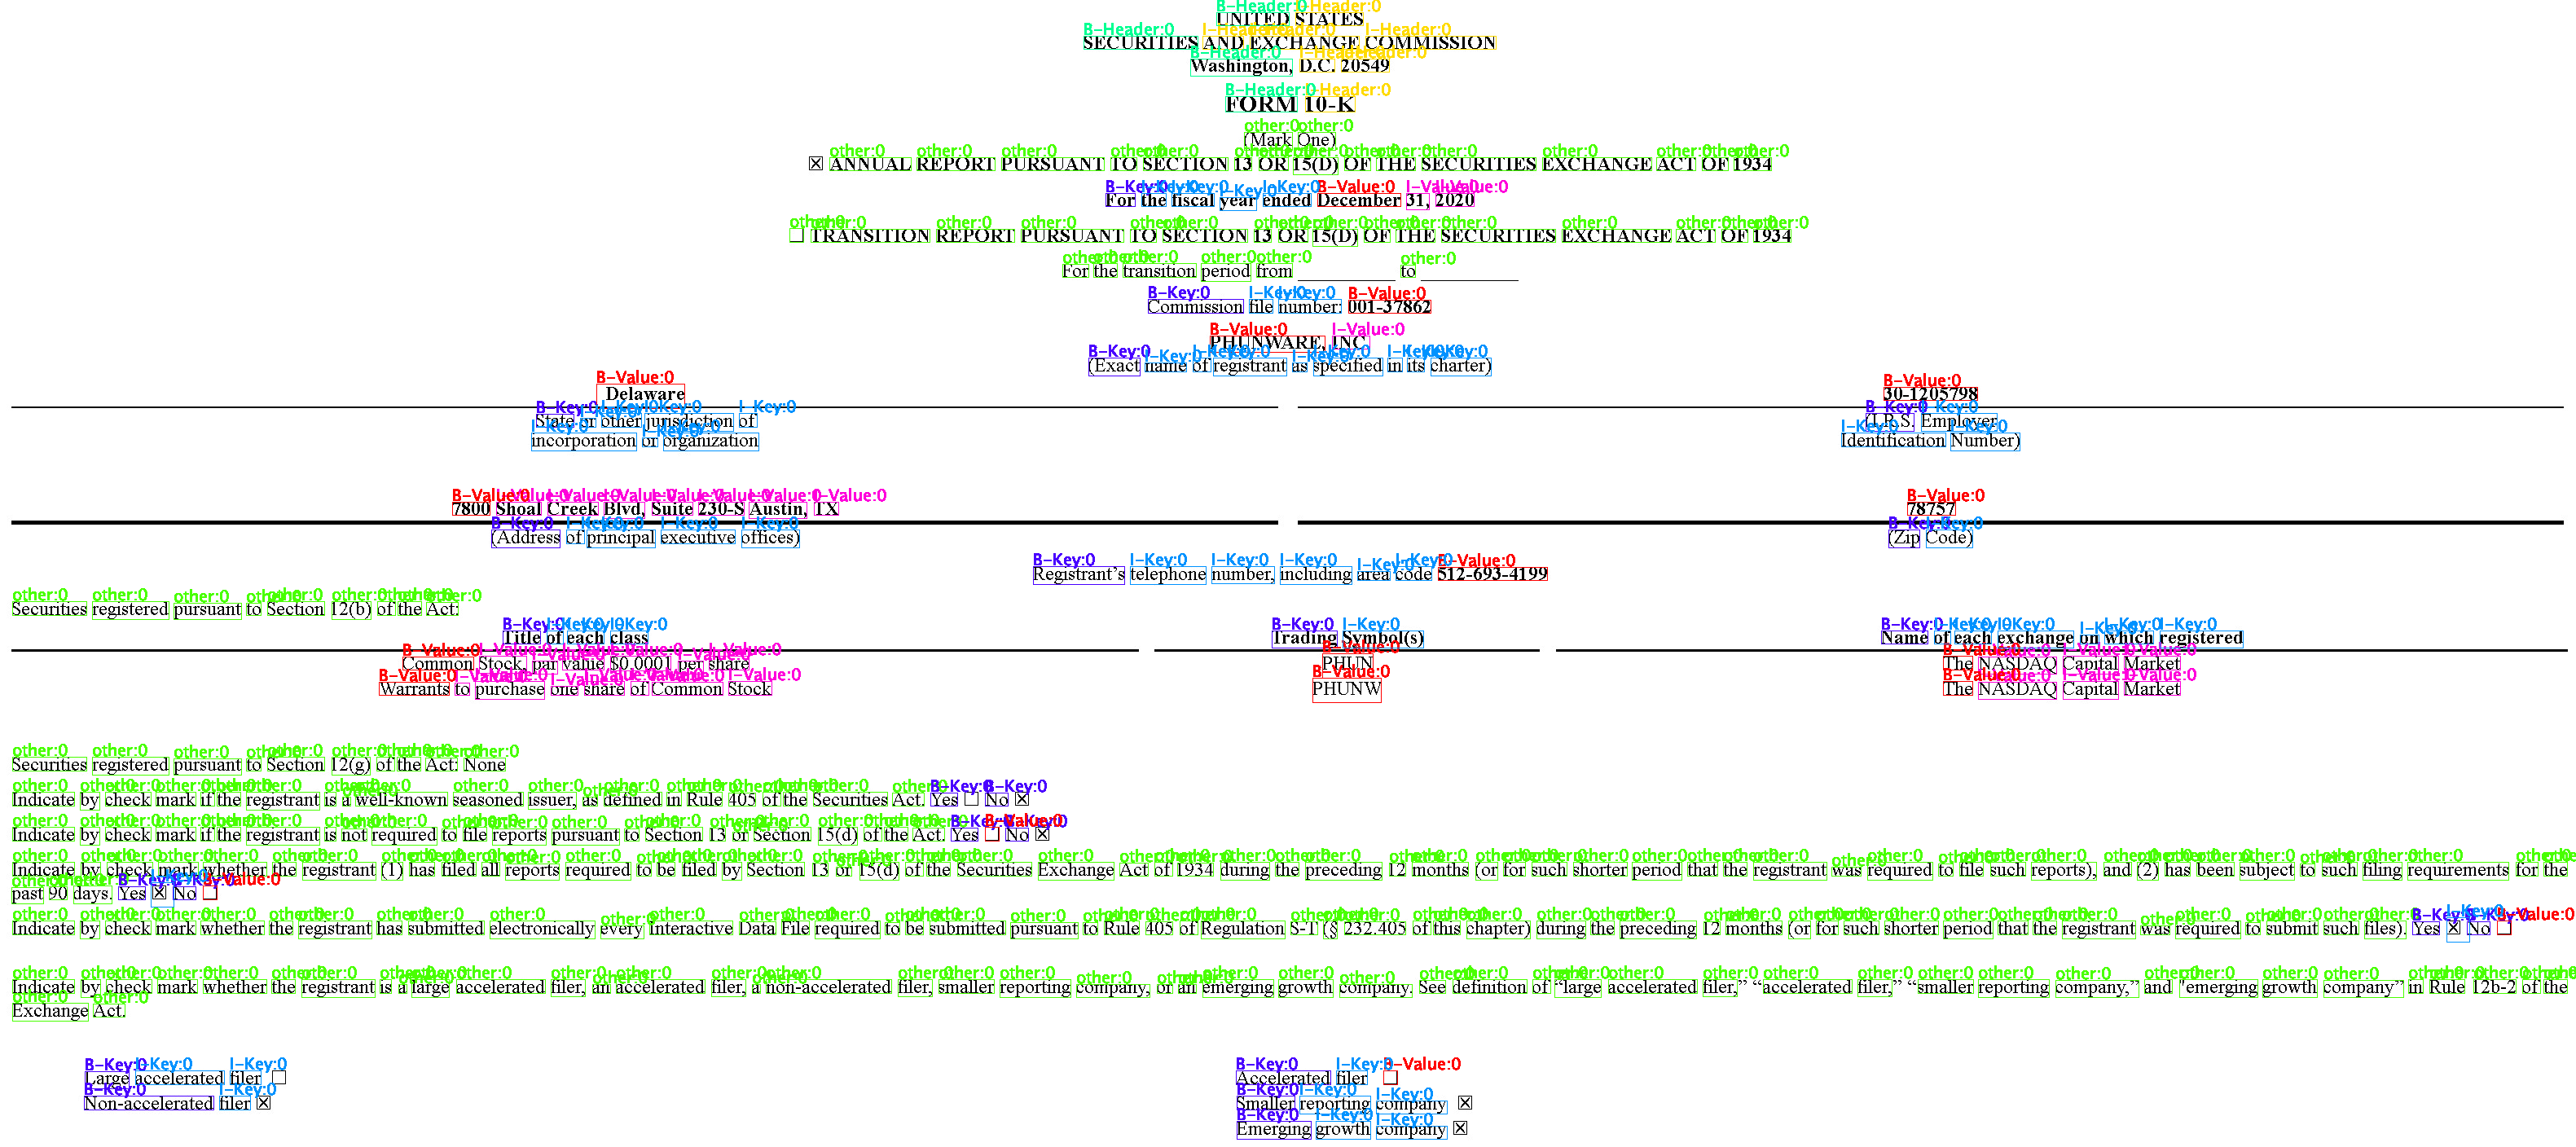


    Image #3:
    Origin: /images/1078/t6-1663287754.jpg
    Resolution: 0 dpi
    Width: 3143 px
    Height: 1216 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


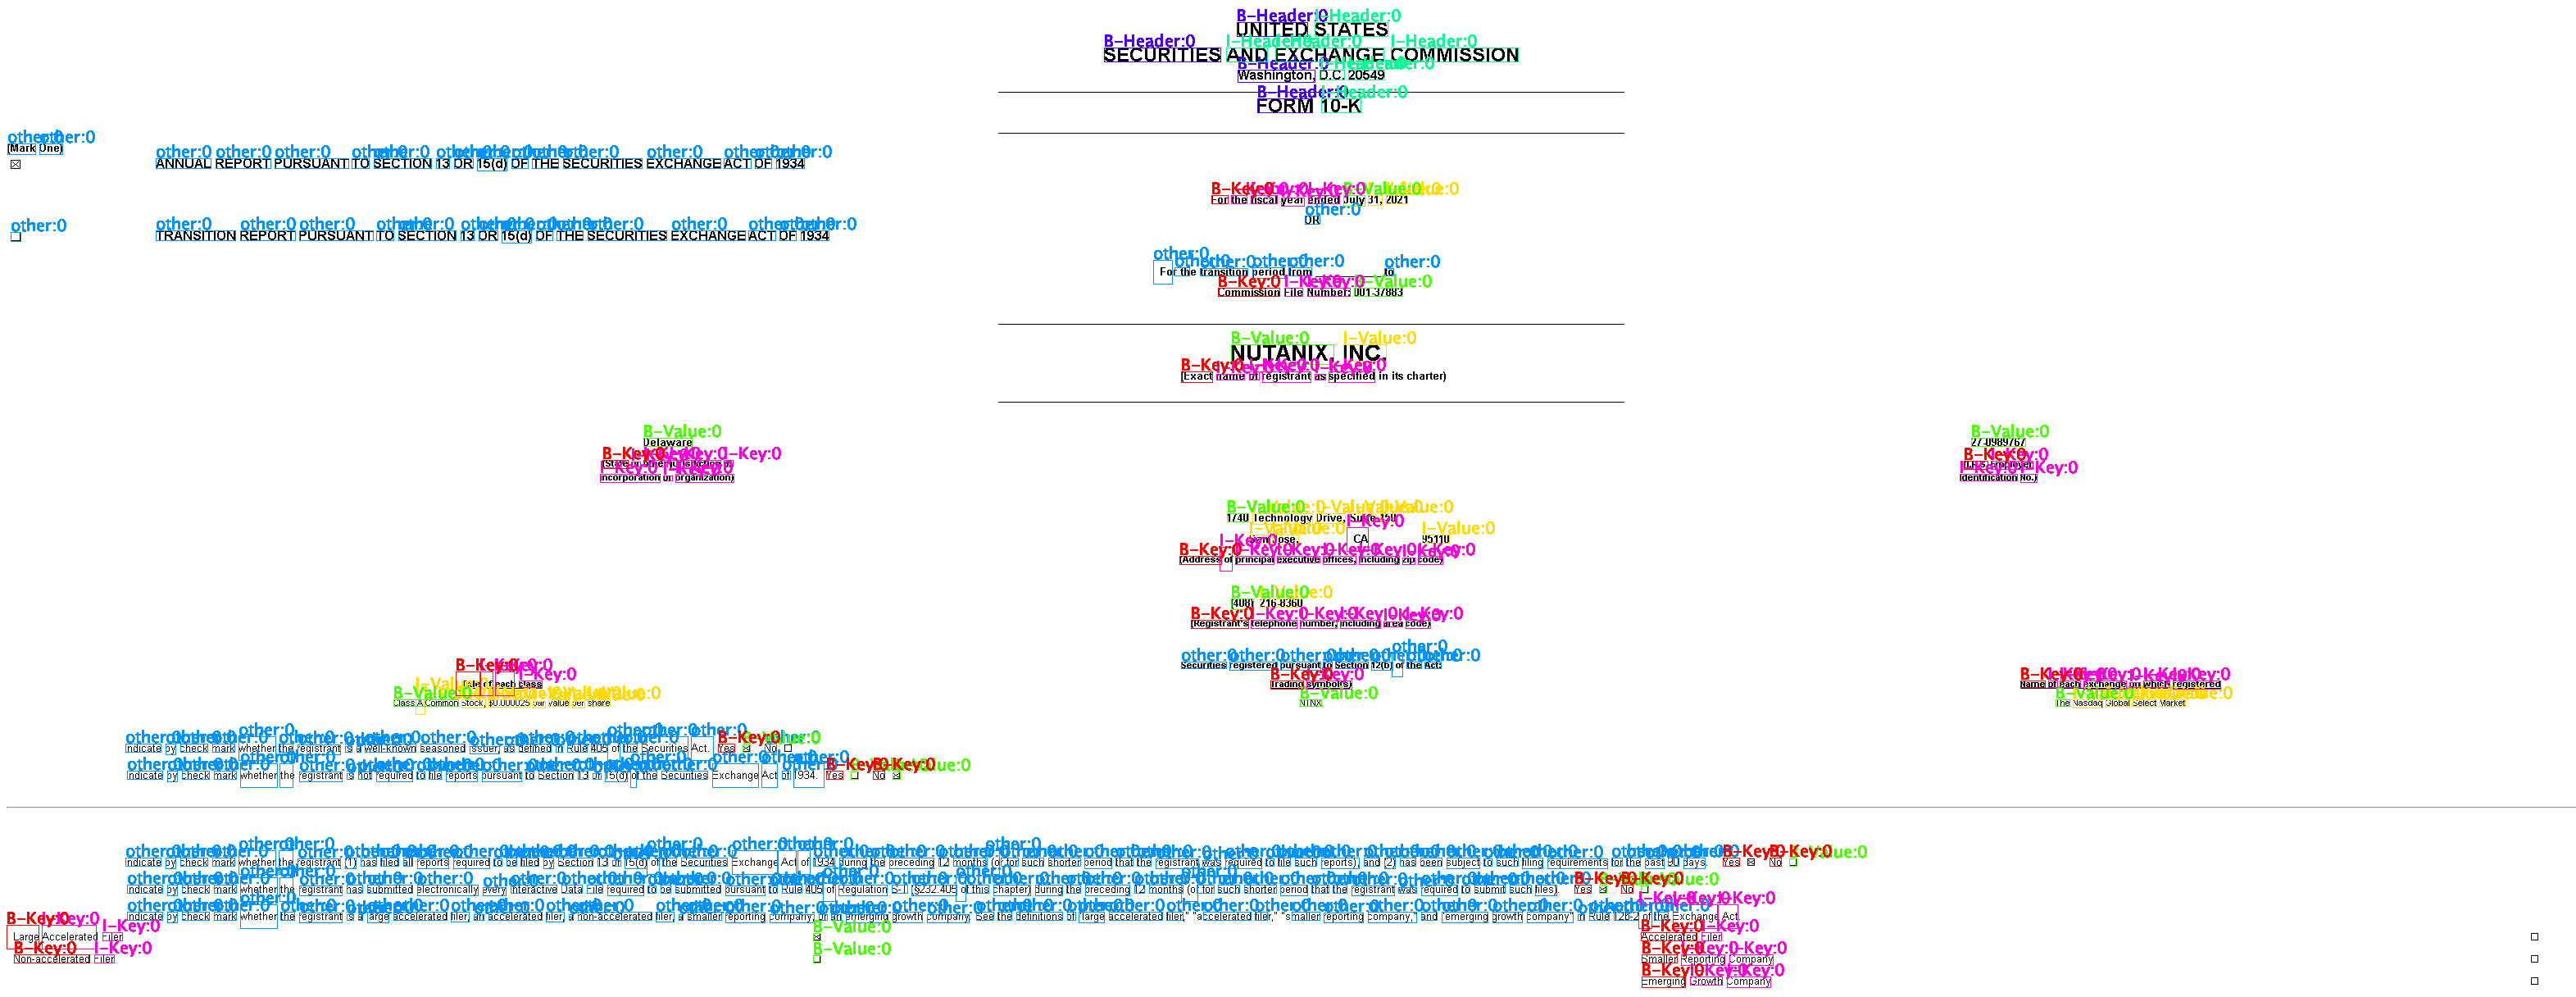


    Image #4:
    Origin: /images/1078/08-1663176725.jpg
    Resolution: 0 dpi
    Width: 3160 px
    Height: 1454 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


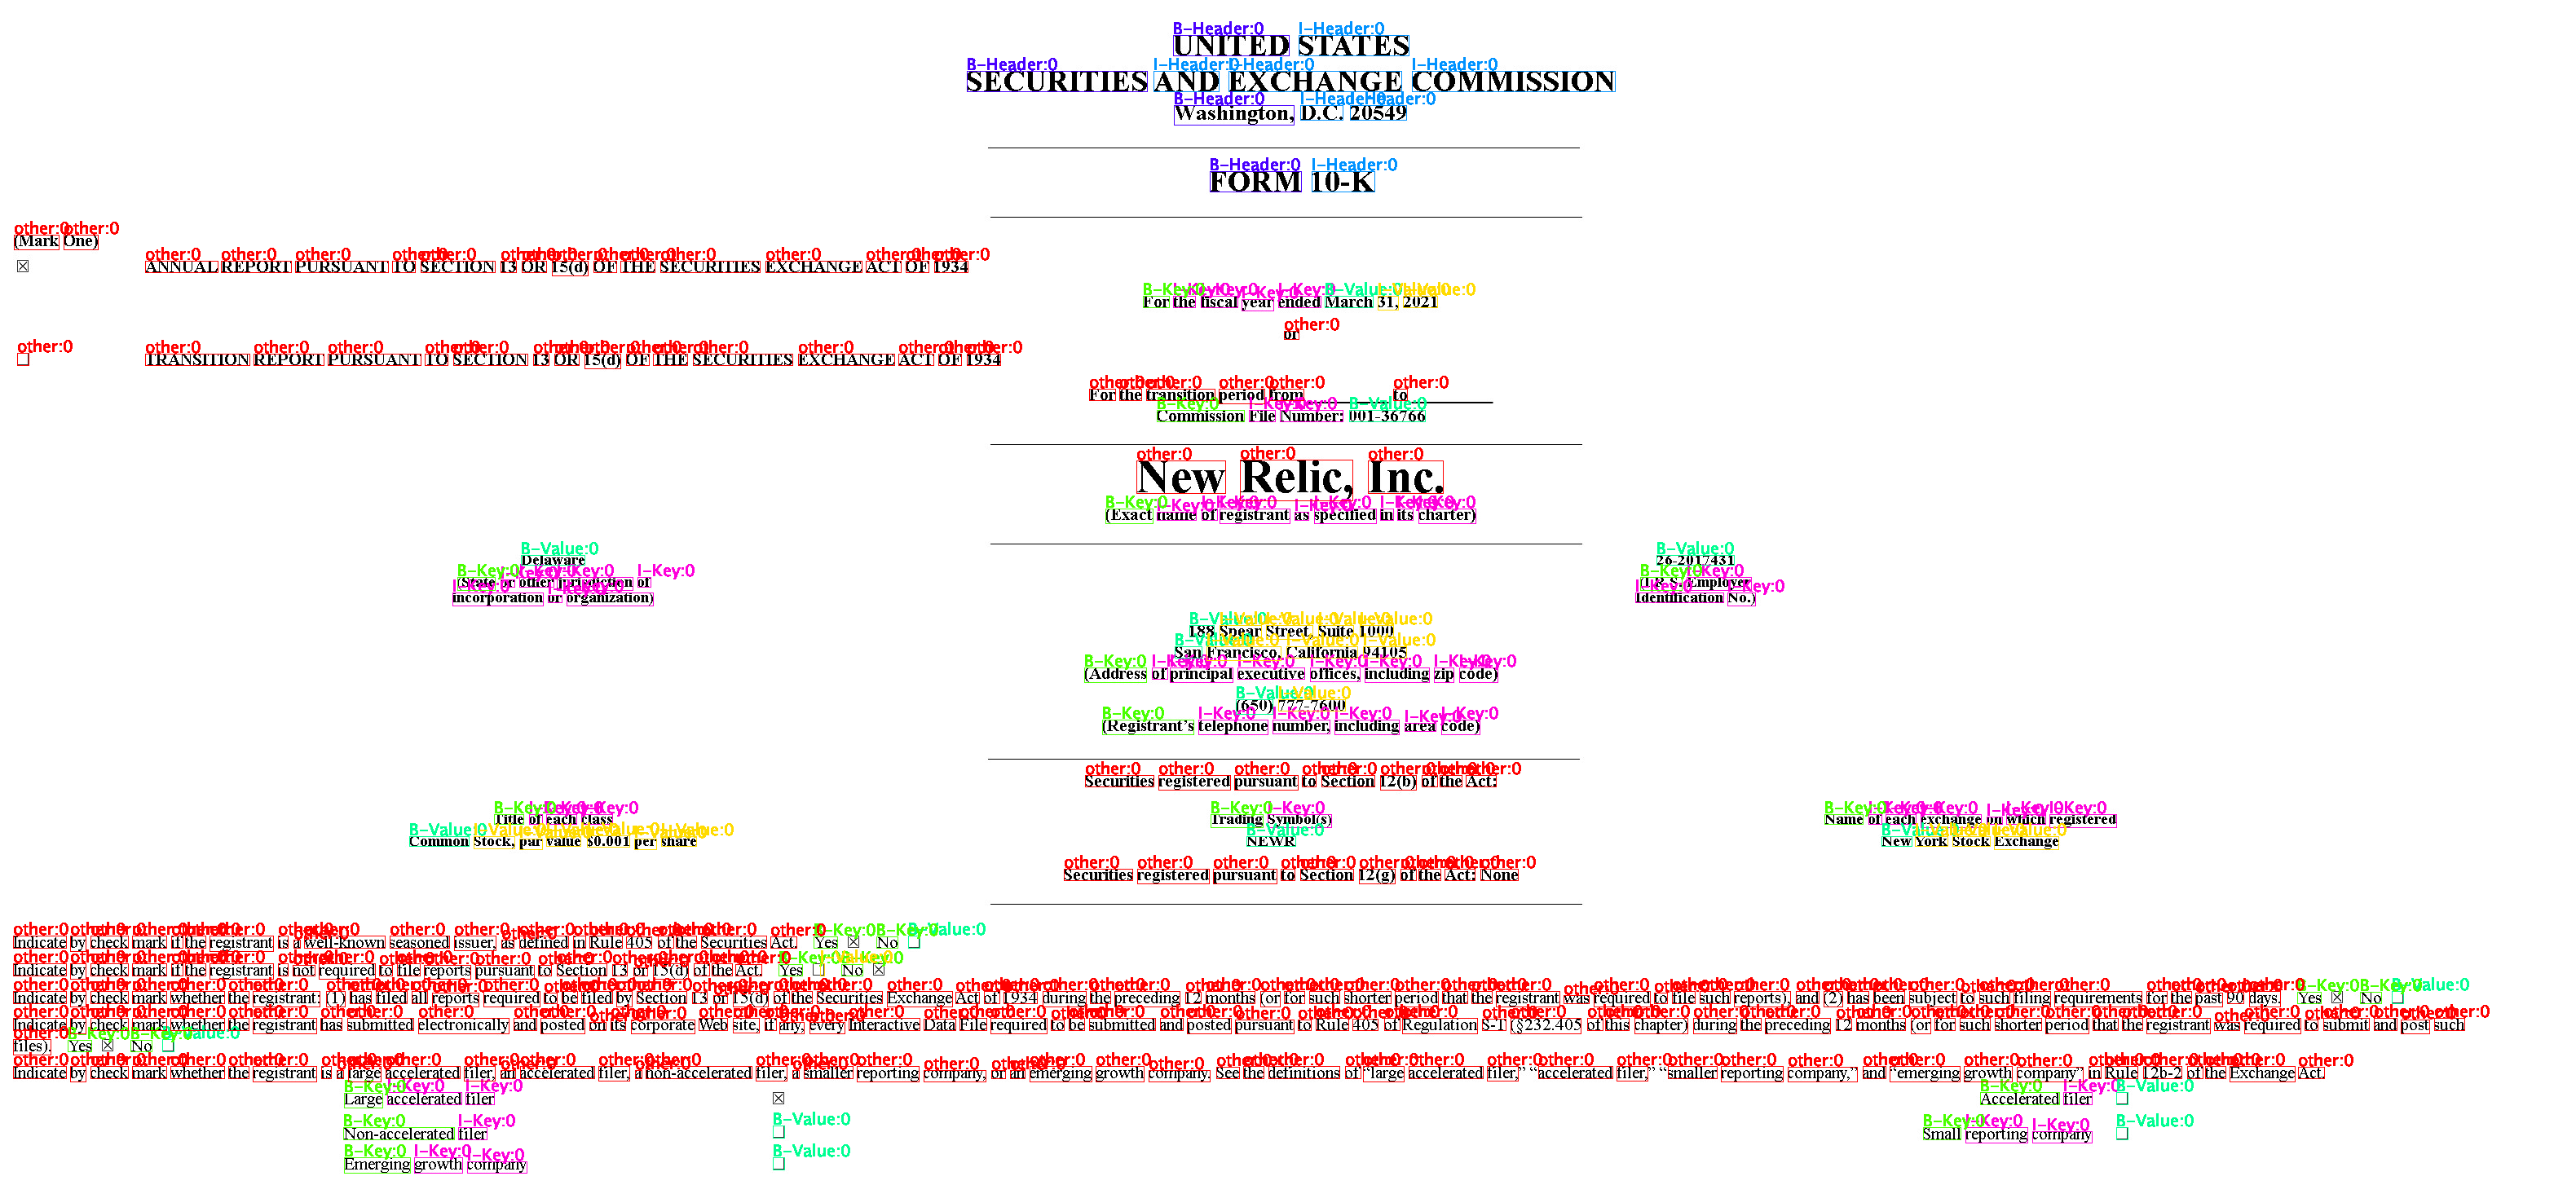

In [6]:
drawEntities = ImageDrawAnnotations() \
      .setInputCol("image") \
      .setInputChunksCol("entities") \
      .setOutputCol("image_with_regions") \
      .setFilledRect(False) \
      .setFontSize(20)

display_images(drawEntities.transform(df), "image_with_regions")

# Get labels

In [7]:
from pyspark.sql.functions import explode
labels = df.select(explode("entities")).select("col.result").distinct() \
            .rdd.map(lambda x : x[0]).collect()
labels

['I-Key', 'I-Value', 'other', 'B-Key', 'B-Value', 'I-Header', 'B-Header']

# Split dataset

In [8]:
train_df, eval_df = df.randomSplit([0.8, 0.2], seed=4)

# Define VisualDocumentNerLilt and specify training params
For demonstration on CPU we are using MaxSteps:100, but for real training need set to 1000...2000

In [9]:
doc_ner_train = VisualDocumentNerLilt() \
            .setInputCols(["tokens", "image"]) \
            .setOutputCol("entities") \
            .setLabels(labels) \
            .setEvalSize(0.1) \
            .setEvalSteps(10) \
            .setMaxSteps(100)

# Run training

In [10]:
fitted_ner = doc_ner_train.fit(train_df.na.drop(subset=['image']).limit(400),
                          base_model="SCUT-DLVCLab/lilt-roberta-en-base",
                          validate=True) \
            .setInputCols(["tokens", "image"]) \
            .setOutputCol("entities")

Some weights of LiltForTokenClassification were not initialized from the model checkpoint at SCUT-DLVCLab/lilt-roberta-en-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
15:15:33, INFO Lilt model Training.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
max_steps is given, it will override any value given in num_train_epochs
/Users/nmelnik/.local/share/virtualenvs/OcrMissedPages-W3gpzUuJ/lib/python3.7/site-packages/transformers/optimization.py:415: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training **

***** Running Evaluation *****
  Num examples: Unknown
  Batch size = 1
/Users/nmelnik/.local/share/virtualenvs/OcrMissedPages-W3gpzUuJ/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: other seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/nmelnik/.local/share/virtualenvs/OcrMissedPages-W3gpzUuJ/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
***** Running Evaluation *****
  Num examples: Unknown
  Batch size = 1
***** Running Evaluation *****
  Num examples: Unknown
  Batch size = 1
***** Running Evaluation *****
  Num examples: Unknown
  Batch size = 1
***** Running Evaluation *****
  Num examples: Unknown
  Batch size = 1
***** Running Evaluation *****
  Num examples: Unknown

Using framework PyTorch: 1.12.0
Overriding 1 configuration item(s)
	- use_cache -> False
Configuration saved in /var/folders/7y/d8c7b2hs0hn433snp6ppr1jw0000gn/T/tmpb6xngmkp/config.json
Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file .cache/lilt_checkpoint/config.json
Model config LiltConfig {
  "_name_or_path": ".cache/lilt_checkpoint",
  "architectures": [
    "LiltForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "channel_shrink_ratio": 4,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "I-KEY",
    "1": "I-VALUE",
    "2": "OTHER",
    "3": "B-KEY",
    "4": "B-VALUE",
    "5": "I-HEADER",
    "6": "B-HEADER"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-HEADER": 6,
    "B-KEY": 3,
    "B-VALUE": 4,
    "I-HEADER": 5,
    "I-KEY":

# Call inference 

In [11]:
test_df = spark.read.format("binaryFile").load("./2023-06-15-09-05-29_Key_Value_10K_Forms/images/1078/14-1663185800.jpg")

binary_to_image = BinaryToImage().setImageType(ImageType.TYPE_3BYTE_BGR)
ocr = ImageToHocr() \
    .setInputCol("image") \
    .setOutputCol("hocr") \
    .setIgnoreResolution(False) \
    .setOcrParams(["preserve_interword_spaces=0"]) \
    .setPageSegMode(PageSegmentationMode.SPARSE_TEXT)

tokenizer = HocrTokenizer() \
    .setInputCol("hocr") \
    .setOutputCol("tokens") \
    .setTokenizerType(TokenizerType.SIMPLE)

drawEntities = ImageDrawAnnotations() \
      .setInputCol("image") \
      .setInputChunksCol("entities") \
      .setOutputCol("image_with_regions") \
      .setFilledRect(False) \
      .setFontSize(20)

fitted_ner.setInputCols(["tokens", "image"]) \
      .setOutputCol("entities")


pipeline = PipelineModel(stages=[
     binary_to_image,
     ocr,
     tokenizer,
     fitted_ner,
     drawEntities
])


    Image #0:
    Origin: file:/Users/nmelnik/IdeaProjects/spark-ocr/workshop/jupyter/Ner/2023-06-15-09-05-29_Key_Value_10K_Forms/images/1078/14-1663185800.jpg
    Resolution: 0 dpi
    Width: 3195 px
    Height: 1231 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


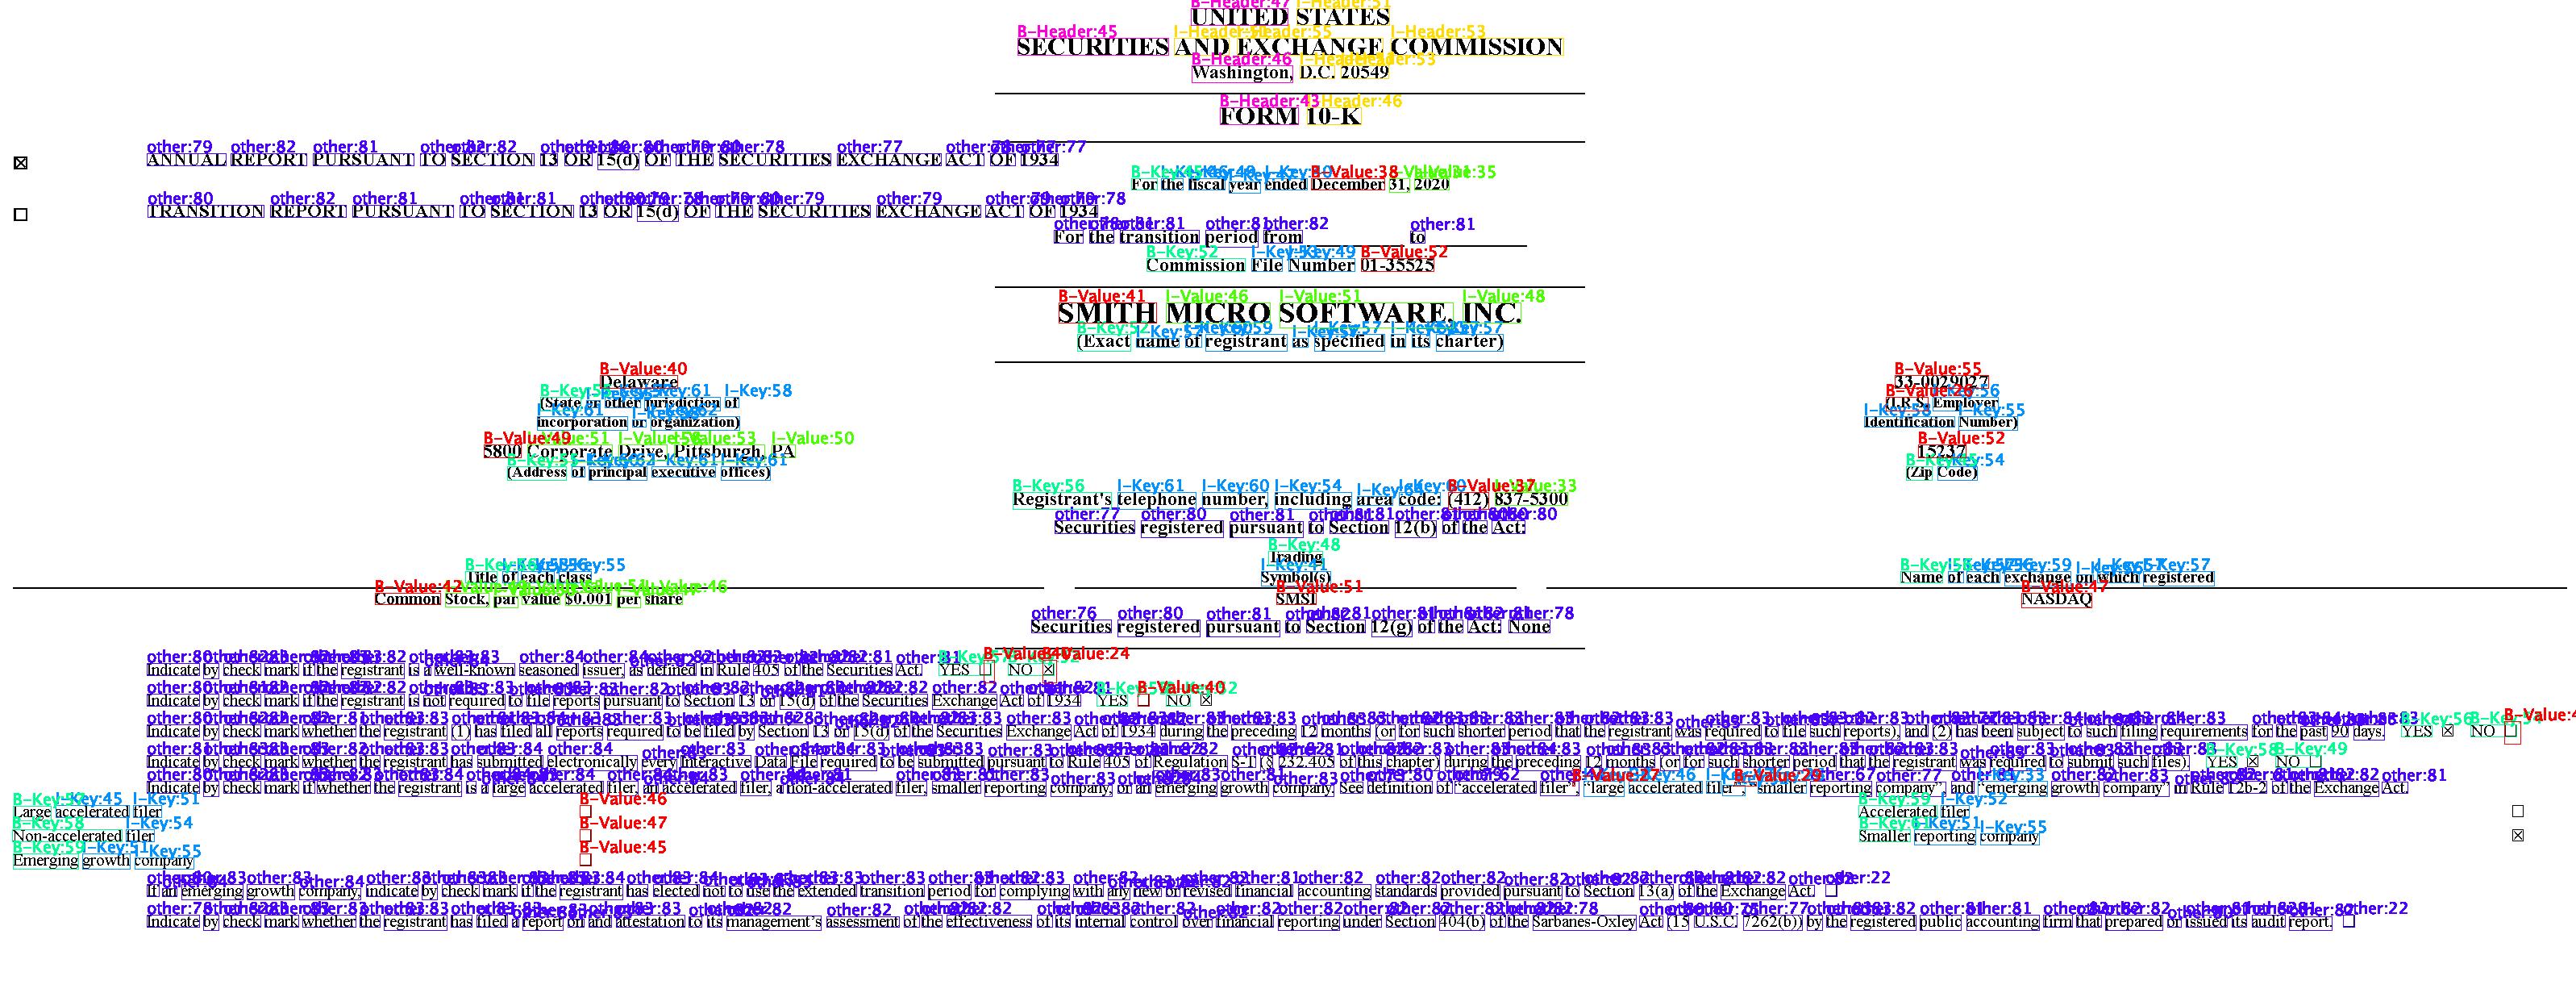

In [12]:
result = pipeline.transform(test_df)
display_images(result, "image_with_regions")

# Store the model

In [13]:
fitted_ner.write().overwrite().save("./lilt")

In [14]:
stored_ner = VisualDocumentNerLilt().load("./lilt")

# Evaluate model

In [15]:
eval_df.count()

14

In [16]:
stored_ner.setInputCols(["tokens", "image"]) \
    .setOutputCol("entities_pred")

VisualDocumentNerLilt_90982a27220f

In [17]:
result = stored_ner.transform(eval_df).select("entities", "entities_pred").cache()

In [18]:
entities = [ i.result for i in result.select("entities.result").collect()]
entities_pred = [ i.result for i in result.select("entities_pred.result").collect()]

In [19]:
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score)


metrics = {
  "precision": precision_score(entities, entities_pred),
  "recall": recall_score(entities, entities_pred),
  "f1": f1_score(entities, entities_pred),
} 

print(metrics)

{'precision': 0.8208333333333333, 'recall': 0.906441717791411, 'f1': 0.8615160349854227}


In [20]:
print(classification_report(entities, entities_pred))

              precision    recall  f1-score   support

      Header       0.90      1.00      0.95        43
         Key       0.86      0.95      0.90       283
       Value       0.84      0.91      0.88       215
        ther       0.65      0.75      0.70       111

   micro avg       0.82      0.91      0.86       652
   macro avg       0.81      0.90      0.86       652
weighted avg       0.82      0.91      0.86       652

